In the previous notebook, we tested a convolutional model for identifying track parameters in single-track events.  Now we will try to deal with the case where there are multiple tracks in the event.  

Author: Dustin Anderson

In [49]:
# Standard imports
import sys

# Package imports
import numpy as np
np.random.seed(2341)

import matplotlib.pyplot as plt
%matplotlib inline

from keras import models, layers
from keras.preprocessing.sequence import pad_sequences


# Local imports
sys.path.append("/home/duanders/AI-HEP.Trk/discrete_extraps")
from drawing import draw_event, draw_input_and_pred

def simulate_straight_track(m, b, det_shape):
    """
    Simulate detector data for one straight track.
    Parameters:
        m: track slope parameter
        b: track first-layer intercept parameter (detector entry point)
        det_shape: tuple of detector shape: (depth, width)
    Returns:
        ndarray of binary detector data for one track.
    """
    x = np.zeros(det_shape)
    idx = np.arange(det_shape[0])
    hits = (idx*m + b).astype(int)
    valid = (hits > 0) & (hits < det_shape[1])
    x[idx[valid], hits[valid]] = 1
    return x

In [20]:
# Training parameters
batch_size = 256
epoch_size = 256000
num_epochs = 15

# Data parameters
det_width = 50
det_depth = 50
det_shape = (det_width, det_depth)

In [21]:
# Number of tracks in each event follows Poisson distribution
mean_tracks = 3
max_tracks = 6

## Model 2: convnet with outputs for multiple tracks

In [28]:
# Generator for single-track events
def gen_tracks(batch_size=batch_size, det_shape=det_shape):
    """Arguments: 
         batch_size: number of events to yield for each call
       Yields: batches of training data for use with the keras fit_generator function
    """
    while True:
        # Entry and exit points are randomized
        bs = np.random.random_sample(size=batch_size)*det_width
        b2s = np.random.random_sample(size=batch_size)*det_width
        ms = (b2s-bs)/det_depth
        tracks = np.zeros((batch_size, 1, det_depth, det_width))
        targets = zip(bs, ms)
        for i, (b, m) in enumerate(targets):
            tracks[i,0] = simulate_straight_track(m, b, det_shape)
        targets = np.asarray(targets)
        yield tracks, targets
        
# Generator for multi-track events.
# Each event contains exactly n_tracks tracks.
# The target track parameters are sorted in increasing order of intercept.
def gen_n_tracks(batch_size=batch_size, det_shape=det_shape, n_tracks=mean_tracks):
    gen_single = gen_tracks(batch_size=n_tracks, det_shape=det_shape)
    while True:
        batch_events = np.zeros((batch_size, 1, det_depth, det_width))
        batch_targets = -np.ones((batch_size, n_tracks, 2))
        for n in range(batch_size):
            tracks,targets = gen_single.next()
            batch_events[n,0] = np.clip( sum( tracks ), 0, 1)
            event_targets = np.asarray(targets)
            batch_targets[n] = event_targets[event_targets[:,0].argsort()] # sort by first column
        yield batch_events, batch_targets
        
# Generator for multi-track events.
# Each event contains up to max_tracks tracks.
# The target track parameters are sorted in increasing order of intercept.
def gen_multi_tracks(batch_size=batch_size, det_shape=det_shape, mean_tracks=mean_tracks):
    gen_single = gen_tracks(batch_size=max_tracks, det_shape=det_shape)
    while True:
        batch_events = np.zeros((batch_size, 1, det_depth, det_width))
        batch_targets = -np.ones((batch_size, max_tracks, 2))
        for n in range(batch_size):
            num_tracks = min( max_tracks, np.random.poisson(mean_tracks) )
            tracks,targets = gen_single.next()
            batch_events[n,0] = np.clip( sum( tracks[:num_tracks] ), 0, 1)
            event_targets = np.asarray(targets[:num_tracks])
            batch_targets[n,:num_tracks] = event_targets[event_targets[:,0].argsort()] # sort by first column
        yield batch_events, batch_targets

[[ 18.16588917   0.34382035]
 [ 49.7126792   -0.76278479]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]]


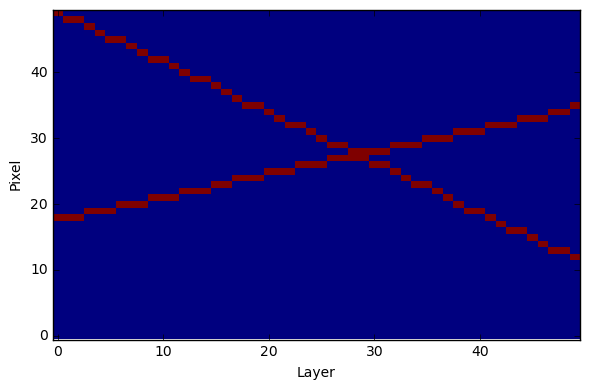

In [24]:
# Test the multi-track generator
tracks, targets = gen_multi_tracks().next()
draw_event(tracks[0,0])
print targets[0]

In [53]:
# Model
def build_model_2():
    """Test model.  Consists of several convolutional layers followed by dense layers and an output layer"""
    input_layer = layers.Input(shape=(1, det_depth, det_width))
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(input_layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPooling2D(pool_size=(2,2))(layer)
    layer = layers.Convolution2D(16, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(16, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Flatten()(layer)
    layer = layers.Dense(20)(layer)
    layer = layers.Dense(2*max_tracks)(layer)
    output_layer = layers.Reshape((max_tracks,2))(layer)
    model = models.Model(input=input_layer, output=output_layer)
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

In [69]:
# Train the model
model_2 = build_model_2()
train_generator = gen_multi_tracks()
%time model_2.fit_generator(train_generator, epoch_size, num_epochs)

Epoch 1/40
256000/256000 [==============================] - 35s - loss: 56.9857    
Epoch 2/40
256000/256000 [==============================] - 35s - loss: 48.1575    
Epoch 3/40
256000/256000 [==============================] - 37s - loss: 46.2265    
Epoch 4/40
256000/256000 [==============================] - 34s - loss: 45.2097    
Epoch 5/40
256000/256000 [==============================] - 35s - loss: 44.3494    
Epoch 6/40
256000/256000 [==============================] - 33s - loss: 43.7542    
Epoch 7/40
256000/256000 [==============================] - 35s - loss: 43.2326    
Epoch 8/40
256000/256000 [==============================] - 33s - loss: 42.9087    
Epoch 9/40
256000/256000 [==============================] - 35s - loss: 42.6445    
Epoch 10/40
256000/256000 [==============================] - 34s - loss: 42.4258    
Epoch 11/40
256000/256000 [==============================] - 35s - loss: 42.3034    
Epoch 12/40
256000/256000 [==============================] - 37s - loss: 4

[[  0.92431891   0.61628342]
 [  8.30983448   0.66591275]
 [ 23.74796867   0.23954588]
 [ 35.09357071  -0.12416899]
 [ 26.13290215  -0.44355983]
 [ 11.55673027  -0.77410448]]


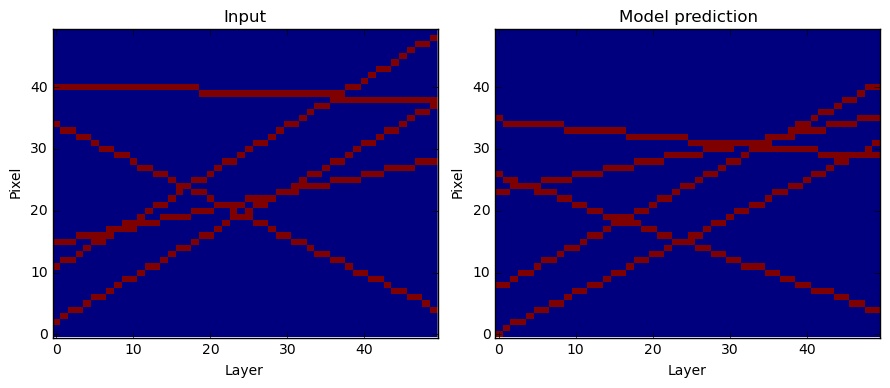

In [72]:
# Visualize prediction
test_event = gen_multi_tracks().next()[0][0]
test_pred = model_2.predict(np.asarray([test_event]))[0]
print test_pred
pred_event = np.clip(sum([ simulate_straight_track(line[1], line[0], det_shape) for line in test_pred 
                         if (line[0]+det_shape[0]*line[1] < det_shape[1] 
                         and line[0]+det_shape[0]*line[1] > 0)]), 0, 1)
draw_input_and_pred(test_event[0], pred_event)

The result is not terrible, but I think the basic idea here is wrong.  The network is trying to learn a 6x2 matrix representing the parameters of up to six tracks.  Each track (1st, 2nd, 3rd, ...) is treated as a row in the output and each row needs to be learned separately.  The -1's indicating "no track" also interfere with the training and performance.  Let's try something else. 

We ultimately want a model that looks at an input image and spits out a list of tracks that it sees.  Instead of outputting a big matrix with all the tracks at once, what if we use an LSTM to output one track at a time?  At each "time step" the LSTM would output the parameters of one track, then change its state to prepare for the next track.  When it doesn't see any more tracks, the model can "shut down" and start outputting -1's for the track parameters.

I'll try to implement that idea.

## Model 3: convnet with output LSTM

In [83]:
# Model
def build_model_3():
    """Test model.  Consists of several convolutional layers followed by dense layers and an LSTM"""
    input_layer = layers.Input(shape=(1, det_depth, det_width))
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(input_layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPooling2D(pool_size=(2,2))(layer)
    layer = layers.Convolution2D(16, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(16, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Flatten()(layer)
    layer = layers.Dense(20)(layer)
    layer = layers.RepeatVector(max_tracks)(layer)
    layer = layers.LSTM(20, return_sequences=True)(layer)
    output_layer = layers.TimeDistributed(layers.Dense(2))(layer)
    model = models.Model(input=input_layer, output=output_layer)
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

In [86]:
# Train the model
model_3 = build_model_3()
train_generator = gen_multi_tracks()
%time model_3.fit_generator(train_generator, epoch_size, num_epochs)

Epoch 1/15
256000/256000 [==============================] - 48s - loss: 126.2105    
Epoch 2/15
256000/256000 [==============================] - 56s - loss: 42.5746    
Epoch 3/15
256000/256000 [==============================] - 50s - loss: 13.6540    
Epoch 4/15
256000/256000 [==============================] - 48s - loss: 5.8855    
Epoch 5/15
256000/256000 [==============================] - 63s - loss: 3.7979    
Epoch 6/15
256000/256000 [==============================] - 58s - loss: 2.6522    
Epoch 7/15
256000/256000 [==============================] - 60s - loss: 2.0833    
Epoch 8/15
256000/256000 [==============================] - 64s - loss: 1.4771    
Epoch 9/15
256000/256000 [==============================] - 64s - loss: 1.3945    
Epoch 10/15
256000/256000 [==============================] - 61s - loss: 1.1488    
Epoch 11/15
256000/256000 [==============================] - 49s - loss: 0.7812    
Epoch 12/15
256000/256000 [==============================] - 59s - loss: 0.7314  

In [87]:
model_3.save("model_3_loss0p5945.h5")

[[ 15.59423677   0.34473929]
 [ 23.92721362   0.43995398]
 [ 44.92571795  -0.22291655]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]]
[[ 14.84936237   0.2683408 ]
 [ 23.21640015   0.10335854]
 [ 44.8633461   -0.35153458]
 [ -1.14415598  -0.93546438]
 [ -0.87830925  -1.03105271]
 [ -0.87907052  -1.06142414]]


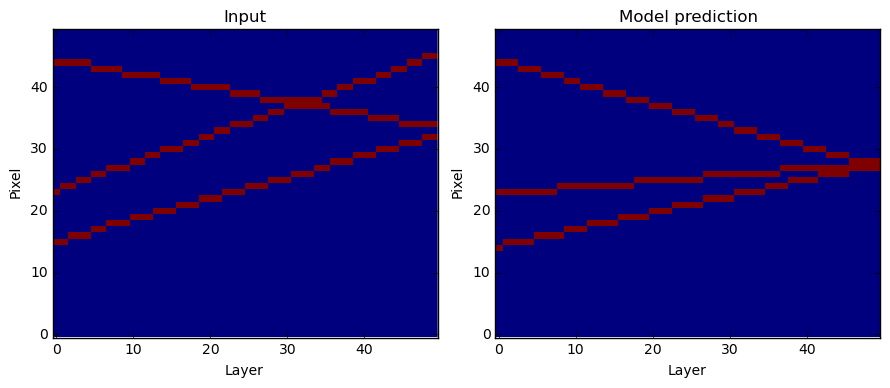

In [95]:
# Visualize prediction
test_data = gen_multi_tracks().next()
test_event = test_data[0][0]
test_target = test_data[1][0]
test_pred = model_3.predict(np.asarray([test_event]))[0]
print test_target
print test_pred
pred_event = np.clip(sum([ simulate_straight_track(line[1], line[0], det_shape) for line in test_pred 
                         if (line[0]+det_shape[0]*line[1] < det_shape[1] 
                         and line[0]+det_shape[0]*line[1] > 0)]), 0, 1)
draw_input_and_pred(test_event[0], pred_event)

The loss is much lower than before, but the model predictions kind of suck!  

Notice that the model does really well at predicting the null -1 values in the target.  This seems to be the main improvement over model_2: the model is good at counting the number of tracks in the image and "shutting off" (i.e. returning only -1s) when there are no more tracks.  So it realizes the basic idea I had in mind.  But we need the model to prioritize getting the track parameters quantitatively correct.

Let's take a step back and try training on events with a fixed number of tracks.

## Model 4: convnet + LSTM for 3-track events

[[  3.47626496   0.56009543]
 [ 28.9768114    0.34842795]
 [ 40.08474785  -0.75126395]]


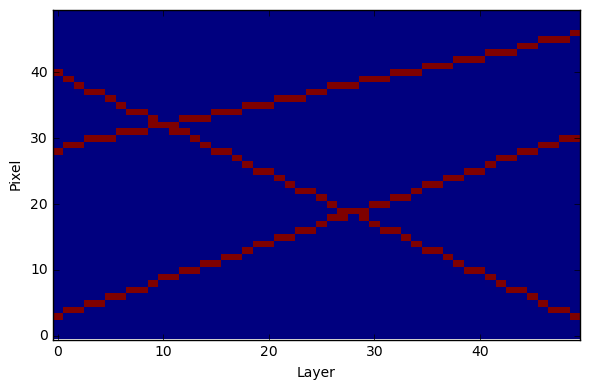

In [31]:
# Test the n-track generator
tracks, targets = gen_n_tracks().next()
draw_event(tracks[0,0])
print targets[0]

In [33]:
# Model
def build_model_4():
    """Test model.  Consists of several convolutional layers followed by dense layers and an LSTM"""
    input_layer = layers.Input(shape=(1, det_depth, det_width))
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(input_layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPooling2D(pool_size=(2,2))(layer)
    layer = layers.Convolution2D(16, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(16, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Flatten()(layer)
    layer = layers.Dense(20)(layer)
    layer = layers.RepeatVector(mean_tracks)(layer)
    layer = layers.LSTM(20, return_sequences=True)(layer)
    output_layer = layers.TimeDistributed(layers.Dense(2))(layer)
    model = models.Model(input=input_layer, output=output_layer)
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

In [35]:
# Train the model
model_4 = build_model_4()
train_generator = gen_n_tracks()
%time model_4.fit_generator(train_generator, epoch_size, num_epochs)

INFO (theano.gof.compilelock): Refreshing lock /home/duanders/.theano/compiledir_Linux-3.19--generic-x86_64-with-Ubuntu-15.04-vivid-x86_64-2.7.9-64/lock_dir/lock


Epoch 1/15
256000/256000 [==============================] - 37s - loss: 228.2562    
Epoch 2/15
256000/256000 [==============================] - 36s - loss: 100.7950    
Epoch 3/15
256000/256000 [==============================] - 38s - loss: 33.9430    
Epoch 4/15
256000/256000 [==============================] - 38s - loss: 7.2479    
Epoch 5/15
256000/256000 [==============================] - 39s - loss: 1.2310    
Epoch 6/15
256000/256000 [==============================] - 39s - loss: 0.3560    
Epoch 7/15
256000/256000 [==============================] - 39s - loss: 0.2051    
Epoch 8/15
256000/256000 [==============================] - 40s - loss: 0.1485    
Epoch 9/15
256000/256000 [==============================] - 35s - loss: 0.1253    
Epoch 10/15
256000/256000 [==============================] - 40s - loss: 0.1075    
Epoch 11/15
256000/256000 [==============================] - 42s - loss: 0.0948    
Epoch 12/15
256000/256000 [==============================] - 42s - loss: 0.0802 

In [36]:
# More training
%time model_4.fit_generator(train_generator, epoch_size, num_epochs)

Epoch 1/15
256000/256000 [==============================] - 39s - loss: 0.0525    
Epoch 2/15
256000/256000 [==============================] - 40s - loss: 0.0531    
Epoch 3/15
256000/256000 [==============================] - 40s - loss: 0.0450    
Epoch 4/15
256000/256000 [==============================] - 42s - loss: 0.0417    
Epoch 5/15
256000/256000 [==============================] - 40s - loss: 0.0412    
Epoch 6/15
256000/256000 [==============================] - 38s - loss: 0.0402    
Epoch 7/15
256000/256000 [==============================] - 40s - loss: 0.0389    
Epoch 8/15
256000/256000 [==============================] - 42s - loss: 0.0353    
Epoch 9/15
256000/256000 [==============================] - 44s - loss: 0.0375    
Epoch 10/15
256000/256000 [==============================] - 43s - loss: 0.0335    
Epoch 11/15
256000/256000 [==============================] - 41s - loss: 0.0329    
Epoch 12/15
256000/256000 [==============================] - 43s - loss: 0.0324    
E

In [47]:
model_4.save("model_4_loss0p0283.h5")

[[  6.13308636e+00   8.15517700e-01]
 [  2.58644821e+01   3.23311156e-01]
 [  3.93270645e+01  -1.20947603e-03]]
[[  6.28803110e+00   7.43328214e-01]
 [  2.60630417e+01   2.98108101e-01]
 [  3.95237923e+01  -1.81970000e-03]]


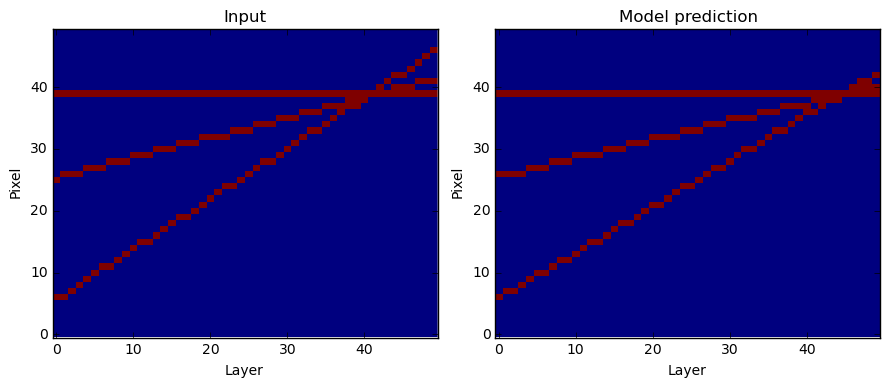

In [63]:
# Visualize prediction
test_data = gen_n_tracks().next()
test_event = test_data[0][0]
test_target = test_data[1][0]
test_pred = model_4.predict(np.asarray([test_event]))[0]
print test_target
print test_pred
pred_event = np.clip(sum([ simulate_straight_track(line[1], line[0], det_shape) for line in test_pred ]), 0, 1)
draw_input_and_pred(test_event[0], pred_event)

It's not perfect.  But there is a lot of room to optimize the model architecture.  The approach should also scale to larger numbers of tracks (to be confirmed).

## Model 5: convnet + LSTM with variable number of tracks and training data masking

We would like the model to deal with a variable number of tracks in the event.  As a first try, let's do this by applying a mask to the training targets.  This will cause the loss function to only consider the model's first N outputs, where N is the (true) number of tracks in the event.  

We can mask the output data using keras's sample_weight mechanism.  However, fit_generator() does not seem to support sample_weight, so we will generate a fixed training set and use the regular fit() function.

In [71]:
# Generate a fixed dataset of multi-track events
epoch_size = 512000
gen_single = gen_tracks(batch_size=max_tracks, det_shape=det_shape)

train_events = np.zeros((epoch_size, 1, det_depth, det_width))
train_targets = -99 * np.ones((epoch_size, max_tracks, 2))
train_weights = np.zeros((epoch_size, max_tracks))
for n in range(epoch_size):
    num_tracks = min( max_tracks, np.random.poisson(mean_tracks) )
    tracks,targets = gen_single.next()
    train_events[n,0] = np.clip( sum( tracks[:num_tracks] ), 0, 1)
    event_targets = np.asarray(targets[:num_tracks])
    train_targets[n,:num_tracks] = event_targets[event_targets[:,0].argsort()] # sort by first column
    train_weights[n,:num_tracks] = np.ones((num_tracks))

[[ 15.66763756   0.10940302]
 [ 18.83608308  -0.2996626 ]
 [ 31.35249821   0.37274601]
 [ 40.52871348  -0.61389101]
 [ 43.93151772  -0.71261226]
 [-99.         -99.        ]]
[ 1.  1.  1.  1.  1.  0.]


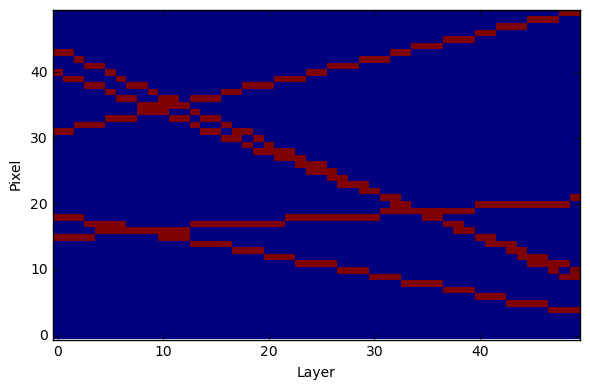

In [72]:
# Check the training data
test_index = np.random.randint(epoch_size)
draw_event(train_events[test_index,0])
print train_targets[test_index]
print train_weights[test_index]

When we train with these sample weights, the loss function will ignore all of the null -99 tracks in the training data.  The model will still produce six tracks' worth of output for each event, and anything it produces beyond the true number of tracks will be garbage.  We can deal with that later.  

The model needs to be compiled slightly differently now, to enable the training weights.

In [73]:
# Model
def build_model_5():
    """Test model.  Consists of several convolutional layers followed by dense layers and an LSTM"""
    input_layer = layers.Input(shape=(1, det_depth, det_width))
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(input_layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPooling2D(pool_size=(2,2))(layer)
    layer = layers.Convolution2D(16, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(16, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Flatten()(layer)
    layer = layers.Dense(20)(layer)
    layer = layers.RepeatVector(max_tracks)(layer)
    layer = layers.LSTM(20, return_sequences=True)(layer)
    output_layer = layers.TimeDistributed(layers.Dense(2))(layer)
    model = models.Model(input=input_layer, output=output_layer)
    model.compile(loss='mean_squared_error', optimizer='Adam', sample_weight_mode="temporal")
    return model

In [74]:
# Train the model
model_5 = build_model_5()
model_5.fit(train_events, train_targets, batch_size=batch_size, nb_epoch=num_epochs, 
           validation_split=0.1, sample_weight=train_weights)

Train on 460800 samples, validate on 51200 samples
Epoch 1/15
460800/460800 [==============================] - 63s - loss: 195.1578 - val_loss: 111.4176
Epoch 2/15
460800/460800 [==============================] - 63s - loss: 95.6665 - val_loss: 90.4567
Epoch 3/15
460800/460800 [==============================] - 63s - loss: 69.3470 - val_loss: 21.7982
Epoch 4/15
460800/460800 [==============================] - 63s - loss: 11.6627 - val_loss: 6.1966
Epoch 5/15
460800/460800 [==============================] - 63s - loss: 4.1037 - val_loss: 2.6410
Epoch 6/15
460800/460800 [==============================] - 64s - loss: 1.9791 - val_loss: 1.4819
Epoch 7/15
460800/460800 [==============================] - 63s - loss: 1.2454 - val_loss: 1.0624
Epoch 8/15
460800/460800 [==============================] - 63s - loss: 0.8761 - val_loss: 0.7678
Epoch 9/15
460800/460800 [==============================] - 63s - loss: 0.6639 - val_loss: 0.6671
Epoch 10/15
460800/460800 [==============================]

In [76]:
# Let's give it a few more epochs
model_5.fit(train_events, train_targets, batch_size=batch_size, nb_epoch=5, 
           validation_split=0.1, sample_weight=train_weights)

Train on 460800 samples, validate on 51200 samples
Epoch 1/5
460800/460800 [==============================] - 63s - loss: 0.3025 - val_loss: 0.3463
Epoch 2/5
460800/460800 [==============================] - 63s - loss: 0.2893 - val_loss: 0.3493
Epoch 3/5
460800/460800 [==============================] - 64s - loss: 0.2836 - val_loss: 0.3412
Epoch 4/5
460800/460800 [==============================] - 63s - loss: 0.2790 - val_loss: 0.3554
Epoch 5/5
460800/460800 [==============================] - 63s - loss: 0.2763 - val_loss: 0.3752


[[  6.19725284  -0.05690172]
 [ 29.70122866  -0.37300588]
 [ 36.02588691  -0.1932298 ]
 [ 44.44537198  -0.0750283 ]]
[[  6.47184467   0.36744663]
 [ 30.3733654   -0.10784769]
 [ 36.58030701  -0.17157298]
 [ 44.50917053  -0.3748337 ]]


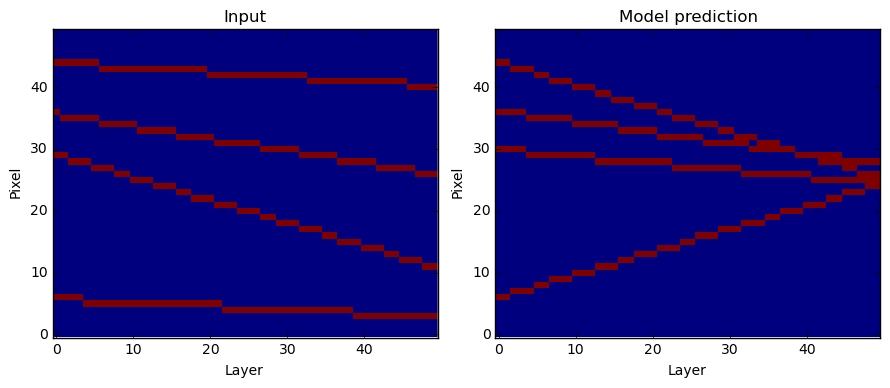

In [94]:
# Visualize prediction
test_index = np.random.randint(epoch_size*0.9,epoch_size)
test_event = train_events[test_index]
test_weights = train_weights[test_index].astype(np.bool_)
test_target = train_targets[test_index][test_weights]
test_pred = model_5.predict(np.asarray([test_event]))[0][test_weights]
print test_target
print test_pred
pred_event = np.clip(sum([ simulate_straight_track(line[1], line[0], det_shape) for line in test_pred ]), 0, 1)
draw_input_and_pred(test_event[0], pred_event)

Looks like this part needs work.

I think the MSE loss function is not quite right.  Deviations in the slope should be penalized more heavily than deviations in the intercept because small changes in slope have a strong effect on the output track.  Join me in the next episode as I investigate this and other ideas. 